In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# input

In [2]:
input_rffa_file = './Assignment_2__Input_FE/output.txt'
arg_skip_row_ind_rffa = 20
input_ffa_dir = './Assignment_1__Output_FE__2nd/'
output_dir = './Assignment_2__Output_FE/'

print(
    input_rffa_file,
    arg_skip_row_ind_rffa,
    input_ffa_dir,
    output_dir,
    sep='\n'
    )

./Assignment_2__Input_FE/output.txt
20
./Assignment_1__Output_FE__2nd/
./Assignment_2__Output_FE/


In [3]:
def create_output_dir(arg_output_dir):
    """create output directory if it does not exist

    arguments:
        [string] --> arg_output_dir = path of the output directory name
    """
    if not os.path.exists(arg_output_dir):
        os.makedirs(arg_output_dir)

In [4]:
create_output_dir(output_dir)
output_dir

'./Assignment_2__Output_FE/'

In [5]:
def list_files(arg_directory_path, arg_regex, arg_column_name='file_path'):
    """return list of files in a directory

    arguments:
        [string] --> arg_directory_path = directory path of the polygons
        [string] --> arg_regex = regex entry
        [string] --> arg_column_name = column's name
    """
    list_files = glob.glob(pathname=arg_directory_path + arg_regex)
    list_files = pd.DataFrame(list_files, columns=[arg_column_name])
    list_files.sort_values(by=[arg_column_name], inplace=True)
    list_files.reset_index(drop=True, inplace=True)

    return list_files

In [6]:
RFFA_results = pd.read_table(
    filepath_or_buffer=input_rffa_file, sep='\s+', header=None, 
    names=['AEP%', 'flow_rate', 'lower_5', 'upper_95'], 
    skiprows=arg_skip_row_ind_rffa, nrows=6
    )
RFFA_results['AEP'] = 100/RFFA_results['AEP%']
RFFA_results.AEP = RFFA_results.AEP.astype(int)
RFFA_results['EY'] = -np.log(1-RFFA_results['AEP%']/100)
RFFA_results['ARI'] = 1/RFFA_results.EY
RFFA_results.ARI = np.ceil(RFFA_results.ARI)
RFFA_results.drop(columns=['AEP%', 'AEP', 'EY'], inplace=True)
RFFA_results = RFFA_results[RFFA_results.columns[[3,0,1,2]]]
RFFA_results['diff_perc_lower'] = 100*RFFA_results.lower_5/RFFA_results.flow_rate
RFFA_results['diff_perc_upper'] = 100*RFFA_results.upper_95/RFFA_results.flow_rate
RFFA_results.to_csv(path_or_buf='{}RFFA_full_data.csv'.format(output_dir), index=False)

RFFA_results

,ARI,flow_rate,lower_5,upper_95,diff_perc_lower,diff_perc_upper
0,2.0,18.1,7.49,43.3,41.381215,239.226519
1,5.0,42.1,18.30,96.9,43.467933,230.166271
2,10.0,66.0,28.80,152.0,43.636364,230.303030
3,20.0,96.2,41.40,225.0,43.035343,233.887734
4,50.0,148.0,62.10,354.0,41.959459,239.189189
5,100.0,197.0,81.30,483.0,41.269036,245.177665


In [7]:
df_RFFA_results = RFFA_results.copy().iloc[2:]
df_RFFA_results.reset_index(drop=True, inplace=True)
df_RFFA_results.to_csv(path_or_buf='{}df_RFFA_full_data.csv'.format(output_dir), index=False)

df_RFFA_results

,ARI,flow_rate,lower_5,upper_95,diff_perc_lower,diff_perc_upper
0,10.0,66.0,28.8,152.0,43.636364,230.303030
1,20.0,96.2,41.4,225.0,43.035343,233.887734
2,50.0,148.0,62.1,354.0,41.959459,239.189189
3,100.0,197.0,81.3,483.0,41.269036,245.177665


In [8]:
RFFA_results = pd.DataFrame(
    data={
        'file_name':['RFFA_full_data.csv'], 
        'prob_fit':['RFFA'], 
        'data_case':['full_data'], 
        'df':[RFFA_results], 
        'df_data':[df_RFFA_results]
        })

RFFA_results

,file_name,prob_fit,data_case,df,df_data
0,RFFA_full_data.csv,RFFA,full_data,ARI flow_rate lower_5 upper_95 diff_p...,ARI flow_rate lower_5 upper_95 diff_p...


In [9]:
FFA_results = list_files(input_ffa_dir, '*_full_data.csv', 'file_name')
FFA_results.file_name = FFA_results.file_name.str.split(pat='/').str[-1]
FFA_results = pd.concat(objs=[FFA_results.iloc[:2], FFA_results.iloc[2:].reset_index(drop=True)], axis=1)
FFA_results.columns = ['file_name', 'df_file_name']
FFA_results['prob_fit'] = FFA_results.file_name.str.split(pat='_').str[0]
FFA_results['data_case'] = FFA_results.file_name.str.split(pat='.').str[0].str.split(pat='_', n=1).str[-1]
FFA_results['df'] = FFA_results.file_name.apply(func=lambda arg: pd.read_csv(filepath_or_buffer='{}{}'.format(input_ffa_dir, arg)))
FFA_results['df_data'] = FFA_results.df_file_name.apply(func=lambda arg: pd.read_csv(filepath_or_buffer='{}{}'.format(input_ffa_dir, arg)))
FFA_results.drop(columns='df_file_name', inplace=True)

FFA_results

,file_name,prob_fit,data_case,df,df_data
0,GEV_full_data.csv,GEV,full_data,ARI flow_rate lower_5 upper_95 diff...,ARI flow_rate lower_5 upper_95 diff_p...
1,LP3_full_data.csv,LP3,full_data,ARI flow_rate lower_5 upper_95 diff...,ARI flow_rate lower_5 upper_95 diff_p...


In [10]:
def plot_ffa(arg_output_dir, arg_prob_fit, arg_data_case, arg_df, arg_df_data):

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(
        arg_df.ARI.to_numpy(),
        arg_df.flow_rate.to_numpy(),
        '-o',
        color='tab:blue',
        linewidth=0.5,
        markersize=3
        )

    ax.fill_between(
        x=arg_df.ARI.to_numpy(),
        y1=arg_df.upper_95.to_numpy(),
        y2=arg_df.lower_5.to_numpy(),
        color='tab:blue',
        alpha=0.2
        )

    for ind1, ind2 in zip(arg_df_data.ARI.to_numpy(), arg_df_data.flow_rate.to_numpy()):
        ax.annotate(
            text=ind2,
            xy=(ind1, ind2),
            xytext=(5, -2.5),
            textcoords='offset points',
            fontsize=8
            )

    for ind1, ind2 in zip(arg_df_data.ARI.to_numpy(), arg_df_data.upper_95.to_numpy()):
        ax.annotate(
            text=ind2,
            xy=(ind1, ind2),
            xytext=(5, 2),
            textcoords='offset points',
            fontsize=8
            )

    for ind1, ind2 in zip(arg_df_data.ARI.to_numpy(), arg_df_data.lower_5.to_numpy()):
        ax.annotate(
            text=ind2,
            xy=(ind1, ind2),
            xytext=(5, -7.5),
            textcoords='offset points',
            fontsize=8
            )

    ax.grid(visible=True, which='both')
    ax.set_xscale(value='log')
    ax.set_title(label='Flood Flow Rate vs Annual Recurrence Interval\n{}_{}'.format(arg_prob_fit, arg_data_case))
    ax.set_xlabel(xlabel='Annual Recurrence Interval in ($year$)')
    ax.set_ylabel(ylabel='Flow Rate in ($m^3/s$)')
    fig.savefig(fname='{}plot_{}_{}.png'.format(arg_output_dir, arg_prob_fit, arg_data_case), bbox_inches='tight')

0    None
dtype: object

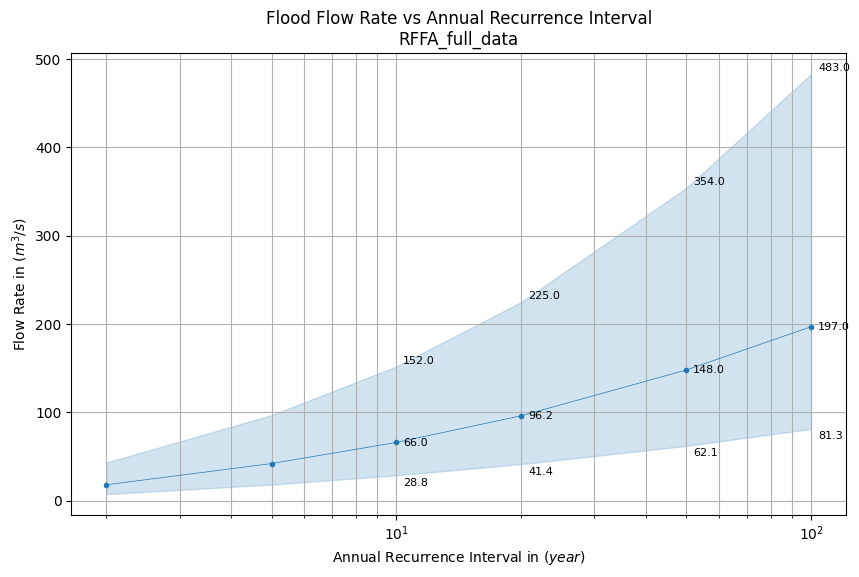

In [11]:
RFFA_results.apply(func=lambda arg: plot_ffa(output_dir, arg.prob_fit, arg.data_case, arg.df, arg.df_data), axis=1)

0    None
1    None
dtype: object

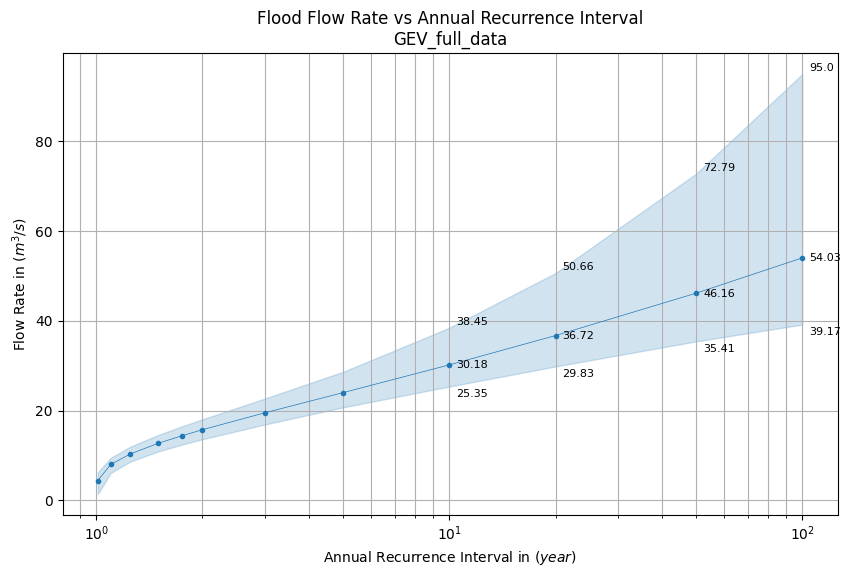

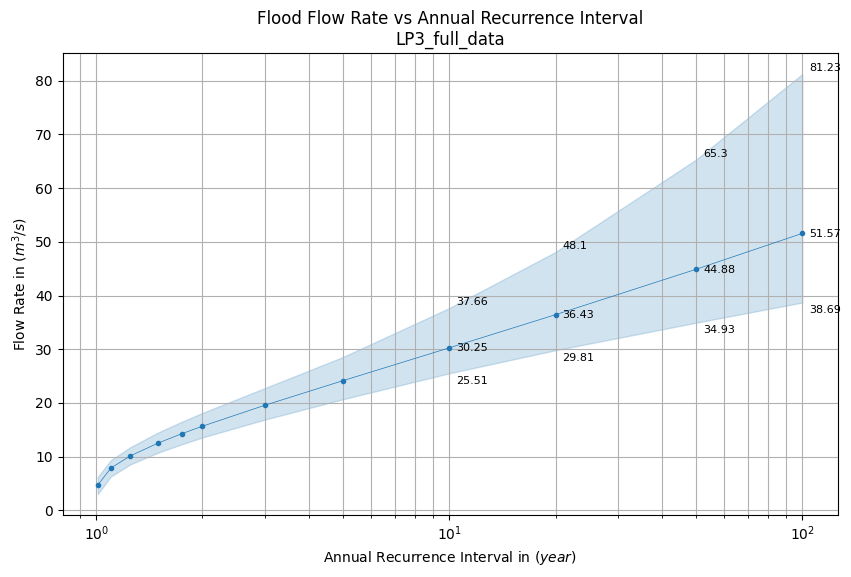

In [12]:
FFA_results.apply(func=lambda arg: plot_ffa(output_dir, arg.prob_fit, arg.data_case, arg.df, arg.df_data), axis=1)

In [13]:
def plot_ffa_comparison(arg_output_dir, arg_df_RFFA, arg_df_FFA):

    data = [arg_df_RFFA, arg_df_FFA]
    colors = ['tab:blue', 'tab:red']
    count = np.arange(stop=len(data))

    value_prob_fit = []

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

    for key, value, color in zip(count, data, colors):
        ax[key].plot(
            value.df.ARI.to_numpy(),
            value.df.flow_rate.to_numpy(),
            '-o',
            color=color,
            linewidth=0.5,
            markersize=2
            )

        ax[key].fill_between(
            x=value.df.ARI.to_numpy(),
            y1=value.df.upper_95.to_numpy(),
            y2=value.df.lower_5.to_numpy(),
            color=color,
            alpha=0.2
            )

        for ind1, ind2 in zip(value.df_data.ARI.to_numpy(), value.df_data.flow_rate.to_numpy()):
            ax[key].annotate(
                text=ind2,
                xy=(ind1, ind2),
                xytext=(5, -2.5),
                textcoords='offset points',
                fontsize=8
                )

        for ind1, ind2 in zip(value.df_data.ARI.to_numpy(), value.df_data.upper_95.to_numpy()):
            ax[key].annotate(
                text=ind2,
                xy=(ind1, ind2),
                xytext=(5, 2),
                textcoords='offset points',
                fontsize=8
                )

        for ind1, ind2 in zip(value.df_data.ARI.to_numpy(), value.df_data.lower_5.to_numpy()):
            ax[key].annotate(
                text=ind2,
                xy=(ind1, ind2),
                xytext=(5, -7.5),
                textcoords='offset points',
                fontsize=8
                )

        ax[key].grid(visible=True, which='both')
        ax[key].set_xscale(value='log')
        ax[key].set_title(label='{}_{}'.format(value.prob_fit, value.data_case), loc='left', fontdict={'fontsize':10})

        value_prob_fit.append(value.prob_fit)

    fig.suptitle(
        t='Flood Flow Rate vs Annual Recurrence Interval\n{} & {} Probability Models'.format(*value_prob_fit), 
        x=0.5, 
        y=0.96
        )
    fig.supxlabel(t='Annual Recurrence Interval in ($year$)', x=0.5, y=0.05)
    fig.supylabel(t='Flow Rate in ($m^3/s$)', x=0.05, y=0.5)

    fig.savefig(
        fname='{}all_{}_and_{}_plots.png'.format(arg_output_dir, *value_prob_fit),
        bbox_inches='tight'
        )

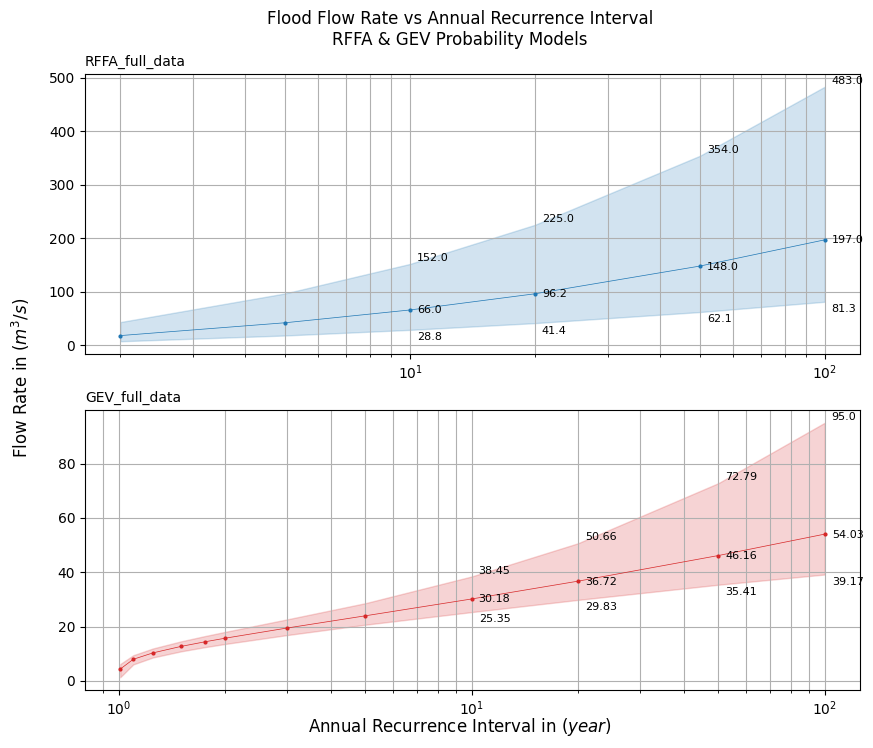

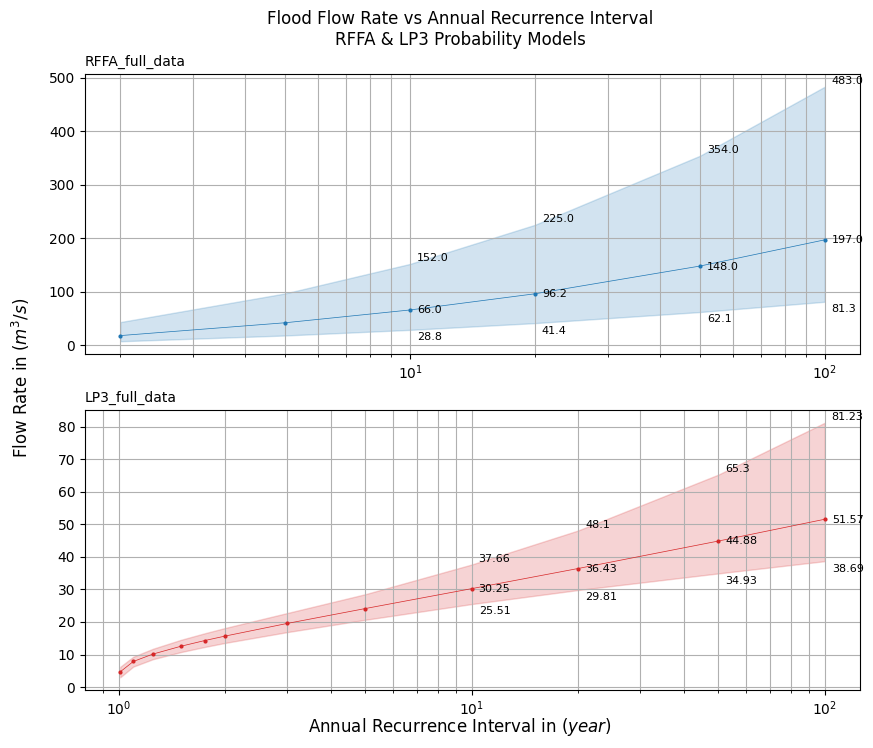

In [14]:
for ind in FFA_results.index:
    var = [output_dir, RFFA_results.iloc[0]] + [FFA_results.iloc[ind]]
    plot_ffa_comparison(*var)

In [15]:
def plot_ffa_overlay(arg_output_dir, arg_df_RFFA, arg_df_FFA):

    data = [arg_df_RFFA, arg_df_FFA]
    colors = ['tab:blue', 'tab:red']
    # count = np.arange(stop=len(data))

    value_prob_fit = []

    fig, ax = plt.subplots(figsize=(10,6))

    for value, color in zip(data, colors):
        ax.plot(
            value.df.ARI.to_numpy(),
            value.df.flow_rate.to_numpy(),
            '-o',
            color=color,
            linewidth=0.5,
            markersize=2
            )

        ax.fill_between(
            x=value.df.ARI.to_numpy(),
            y1=value.df.upper_95.to_numpy(),
            y2=value.df.lower_5.to_numpy(),
            color=color,
            alpha=0.2
            )

        for ind1, ind2 in zip(value.df_data.ARI.to_numpy(), value.df_data.flow_rate.to_numpy()):
            ax.annotate(
                text=ind2,
                xy=(ind1, ind2),
                xytext=(5, -2.5),
                textcoords='offset points',
                fontsize=8
                )

        value_prob_fit.append(value.prob_fit)

    ax.grid(visible=True, which='both')
    ax.set_xscale(value='log')
    ax.set_title(label='Flood Flow Rate vs Annual Recurrence Interval\n{} & {} Probability Models'.format(*value_prob_fit))
    ax.set_xlabel(xlabel='Annual Recurrence Interval in ($year$)')
    ax.set_ylabel(ylabel='Flow Rate in ($m^3/s$)')

    fig.savefig(
        fname='{}overlay_{}_and_{}_plots.png'.format(arg_output_dir, *value_prob_fit),
        bbox_inches='tight'
        )

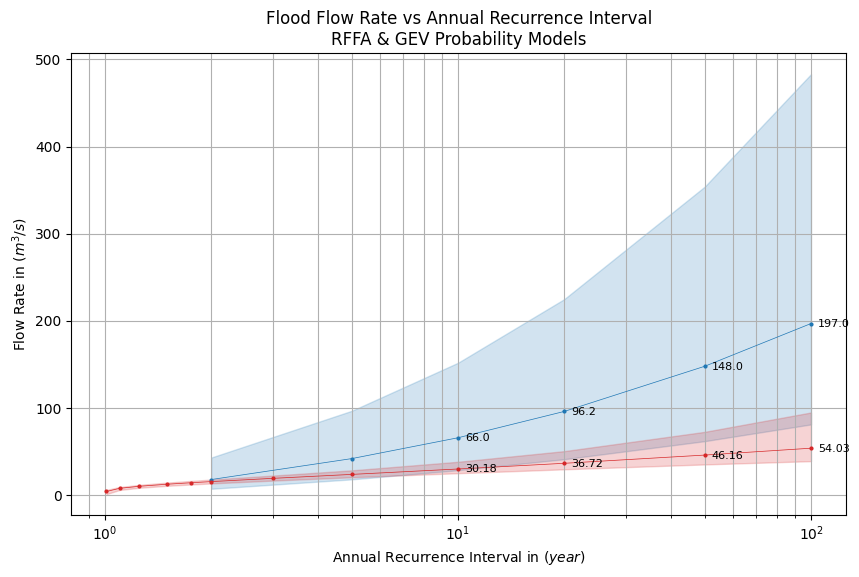

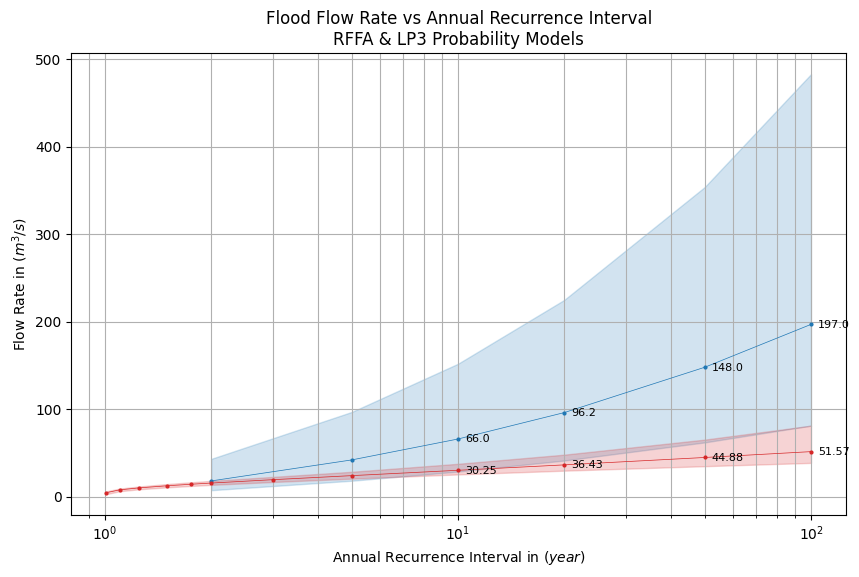

In [16]:
for ind in FFA_results.index:
    var = [output_dir, RFFA_results.iloc[0]] + [FFA_results.iloc[ind]]
    plot_ffa_overlay(*var)

In [17]:
df_comparison = []

for ind in FFA_results.index:
    df = []
    label_df = []
    df_comp = pd.concat(objs=[RFFA_results.iloc[0], FFA_results.iloc[ind]])
    for ind1, ind2, ind3 in zip(df_comp.prob_fit, df_comp.data_case, df_comp.df_data):
        ind3.index = pd.MultiIndex.from_arrays(arrays=[[ind1]*len(ind3), [ind2]*len(ind3)])
        df.append(ind3)
        label_df.append(ind1)
    df = pd.concat(objs=df)
    df.to_csv(path_or_buf='{}all_df_{}_and_{}.csv'.format(output_dir, *label_df))
    df_comparison.append(df)

df_comparison

[                  ARI  flow_rate  lower_5  upper_95  diff_perc_lower  \
 RFFA full_data   10.0      66.00    28.80    152.00        43.636364   
      full_data   20.0      96.20    41.40    225.00        43.035343   
      full_data   50.0     148.00    62.10    354.00        41.959459   
      full_data  100.0     197.00    81.30    483.00        41.269036   
 GEV  full_data   10.0      30.18    25.35     38.45        83.996024   
      full_data   20.0      36.72    29.83     50.66        81.236383   
      full_data   50.0      46.16    35.41     72.79        76.711438   
      full_data  100.0      54.03    39.17     95.00        72.496761   
 
                 diff_perc_upper  
 RFFA full_data       230.303030  
      full_data       233.887734  
      full_data       239.189189  
      full_data       245.177665  
 GEV  full_data       127.402253  
      full_data       137.962963  
      full_data       157.690641  
      full_data       175.828244  ,
                   ARI  f